In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.feature_selection import mutual_info_regression, SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

# numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

df_reg = df.drop(categorical_attr_list, axis=1)
df_reg = df_reg.join(pd.get_dummies(df[categorical_attr_list], columns=categorical_attr_list).astype(int))
df_reg.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,...,actor_actor_24,actor_actor_3,actor_actor_4,actor_actor_5,actor_actor_6,actor_actor_7,actor_actor_8,actor_actor_9,sex_F,sex_M
0,160160,0.114319,7.137790e-07,0.004283,-0.042603,0.048157,-0.013550,-0.006104,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
1,156956,0.149963,9.554485e-07,0.005084,-0.037018,0.058472,-0.015822,-0.007294,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
2,152152,0.139618,9.176213e-07,0.004886,-0.036652,0.062683,-0.014923,-0.006714,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
3,169769,0.137665,8.108948e-07,0.002956,-0.026245,0.026215,-0.009399,-0.004364,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
4,172972,0.140289,8.110521e-07,0.003085,-0.032349,0.028961,-0.008942,-0.004242,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
features_to_correct = ['stft_min', 'sc_min']
(df[features_to_correct] < 0).any()

stft_min    False
sc_min      False
dtype: bool

# stft_min

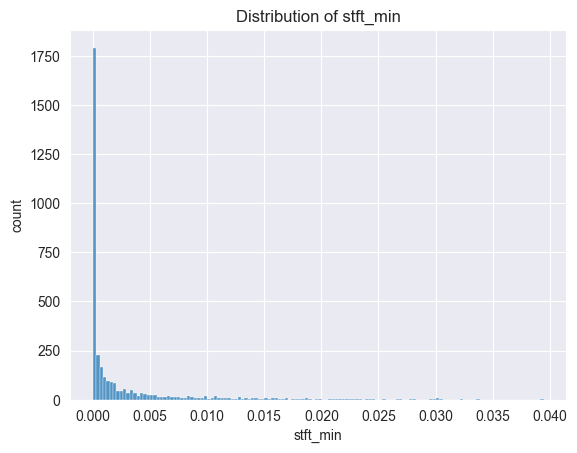

In [5]:
sns.histplot(data=df, x=df['stft_min'], stat='density')
plt.xlabel(f'stft_min')
plt.ylabel('count')
plt.title(f'Distribution of stft_min')
plt.show()

In [6]:
# rows to be fixed, do not reset indexes!
df_zero = df_reg[df_reg['stft_min'] == 0]
df_nz = df_reg[df_reg['stft_min'] != 0].reset_index(drop=True)

# dataframe has been one hot encoded
split_index = df_nz.index[df_nz['actor_actor_19'] == 1][0]

df_train = df_nz[:split_index]
df_test = df_nz[split_index:]

y_train = np.log10(df_train['stft_min'].to_numpy())
y_test = np.log10(df_test['stft_min'].to_numpy())

df_zero = df_zero.drop(['stft_min'], axis=1)
df_train = df_train.drop(['stft_min'], axis=1)
df_test = df_test.drop(['stft_min'], axis=1)

X_to_pred = df_zero.to_numpy()
X_train = df_train.to_numpy()
X_test = df_test.to_numpy()

display(df_train.shape, df_test.shape, X_to_pred.shape)

(1058, 284)

(362, 284)

(1009, 284)

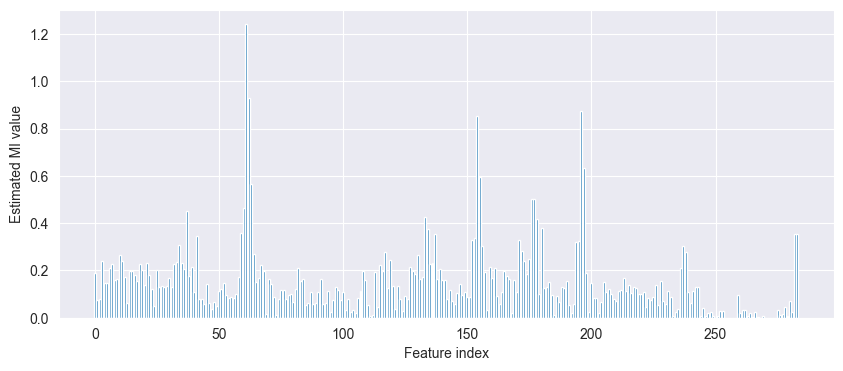

In [7]:
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')
f_selector.fit(X_train, y_train)

plt.figure(figsize=(10, 4))
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('Feature index')
plt.ylabel('Estimated MI value')
plt.show()

In [8]:
f_selector = SelectKBest(score_func=mutual_info_regression, k=20)
f_selector.fit(X_train, y_train)

X_train = f_selector.transform(X_train)
X_test = f_selector.transform(X_test)
X_to_pred = f_selector.transform(X_to_pred)

In [9]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_to_pred = scaler.fit_transform(X_to_pred)

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized.
def objective_fun(trial):

    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    gamma = trial.suggest_float('gamma', 0, 5)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 3)
    subsample = trial.suggest_float('subsample', 0.4, 1)

    xgb = XGBRegressor(booster=booster, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, subsample=subsample)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    error = mean_squared_error(y_test, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=100)

[I 2023-06-01 18:03:44,087] A new study created in memory with name: no-name-ff3bab58-629e-4890-a387-ff2ec61d4f82
[I 2023-06-01 18:03:44,443] Trial 0 finished with value: 0.08976561614863467 and parameters: {'booster': 'dart', 'gamma': 0.9448585596123854, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.9084188407851309}. Best is trial 0 with value: 0.08976561614863467.
[I 2023-06-01 18:03:44,562] Trial 1 finished with value: 0.09001138881451336 and parameters: {'booster': 'gbtree', 'gamma': 3.452890708319391, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.8567508666572349}. Best is trial 0 with value: 0.08976561614863467.
[I 2023-06-01 18:03:45,080] Trial 2 finished with value: 0.08853114221022718 and parameters: {'booster': 'dart', 'gamma': 4.528839910411082, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.9922258736486481}. Best is trial 2 with value: 0.08853114221022718.
[I 2023-06-01 18:03:45,313] Trial 3 finished with value: 0.09598510945213949 and parameters: 

In [11]:
best_params = study.best_params

xgb = XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)

print(best_params)
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

{'booster': 'dart', 'gamma': 1.8105008713501065, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7682872349602288}
Root mean squared error = 0.2862
R-squared = 0.8207


In [12]:
y_pred = xgb.predict(X_to_pred)
y_pred = np.power(10, y_pred)
y_pred

array([1.3896951e-02, 2.5098152e-03, 1.7802047e-02, ..., 5.6518373e-05,
       5.6518373e-05, 5.0185328e-05], dtype=float32)

In [13]:
# negative values predicted
np.count_nonzero(y_pred < 0)

0

In [14]:
df_zero['stft_min'] = y_pred
df.update(df_zero)

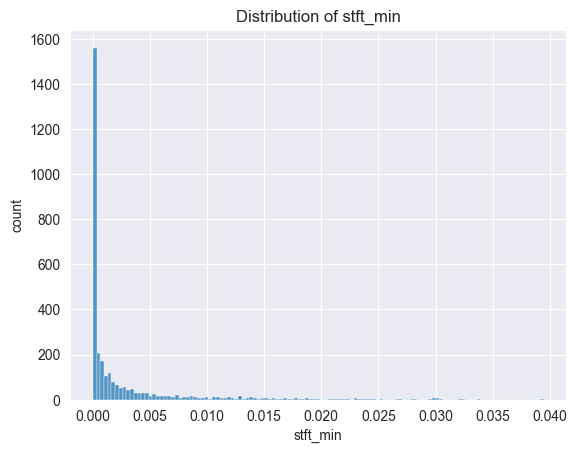

In [15]:
sns.histplot(data=df, x='stft_min', stat='density')
plt.xlabel(f'stft_min')
plt.ylabel('count')
plt.title(f'Distribution of stft_min')
plt.show()

In [16]:
df['stft_min'].corr(df['stft_q01'], method='spearman')

0.9307185483227972